# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [1]:
#!pip install shap -U
#!pip install scikit-learn --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from math import ceil
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore', category=FitFailedWarning)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import LogisticRegression

from scipy.stats import loguniform

from catboost import CatBoostClassifier, Pool, metrics, cv

pd.options.display.max_columns = 0

In [3]:
RS = 42

### Шаг 1. Откройте файлы с данными

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

    id — номер записи;
    adults — количество взрослых постояльцев;
    arrival_date_year — год заезда;
    arrival_date_month — месяц заезда;
    arrival_date_week_number — неделя заезда;
    arrival_date_day_of_month — день заезда;
    babies — количество младенцев;
    booking_changes — количество изменений параметров заказа;
    children — количество детей от 3 до 14 лет;
    country — гражданство постояльца;
    customer_type — тип заказчика:
        Contract — договор с юридическим лицом;
        Group — групповой заезд;
        Transient — не связано с договором или групповым заездом;
        Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
    days_in_waiting_list — сколько дней заказ ожидал подтверждения;
    distribution_channel — канал дистрибуции заказа;
    is_canceled — отмена заказа;
    is_repeated_guest — признак того, что гость бронирует номер второй раз;
    lead_time — количество дней между датой бронирования и датой прибытия;
    meal — опции заказа:
        SC — нет дополнительных опций;
        BB — включён завтрак;
        HB — включён завтрак и обед;
        FB — включён завтрак, обед и ужин.
    previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
    previous_cancellations — количество отменённых заказов у клиента;
    required_car_parking_spaces — необходимость места для автомобиля;
    reserved_room_type — тип забронированной комнаты;
    stays_in_weekend_nights — количество ночей в выходные дни;
    stays_in_week_nights — количество ночей в будние дни;
    total_nights — общее количество ночей;
    total_of_special_requests — количество специальных отметок.

In [4]:
try:
    df = pd.read_csv('datasets/hotel_train.csv')
    test_df = pd.read_csv('datasets/hotel_test.csv')
except:
    df = pd.read_csv('/datasets/hotel_train.csv')
    test_df = pd.read_csv('/datasets/hotel_test.csv')

In [5]:
SUMMER_MONTHS = ['June', 'July', 'August']
MID_MONTHS = ['September', 'October', 'November', 'March', 'April', 'May']

In [6]:
df.head(2)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2


In [7]:
df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [8]:
assert (df.dtypes == test_df.dtypes).sum() == df.shape[1]

Все типы у сетов совпадают, колонка с номером записи идентична сквозному индексу, потому не представляет особого интереса.

### Шаг 2. Предобработка и исследовательский анализ данных

In [9]:
assert df.isna().sum()[df.isna().sum() != 0].empty
assert test_df.isna().sum()[test_df.isna().sum() != 0].empty

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0
babies,65229.0,0.007236,0.098790,0.0,0.0,0.0,0.0,10.0


Уберём пары выбросов в количестве младенцев, это явные опечатки или ошибки. 

In [11]:
df.babies.value_counts()

0.0     64777
1.0       447
2.0         3
10.0        1
9.0         1
Name: babies, dtype: int64

In [12]:
df.replace({'babies': {10: 0, 9: 0, 2: 1}}, inplace=True)
df.replace({'babies': {1: True, 0: False}}, inplace=True)
test_df.replace({'babies': {2: True, 1: True, 0: False}}, inplace=True)

In [13]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,32412.0,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.0,2.0,3.0,6.0
adults,32412.0,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0
children,32412.0,0.083765,0.343470,0.0,0.0,0.0,0.0,3.0
is_repeated_guest,32412.0,0.031377,0.174338,0.0,0.0,0.0,0.0,1.0


Из таблиц явно видна особенность сета: предсказание по данным 2015-2016 годов пытаемся предсказать значения в 2017 (и, в теории, дальше). Естественно, как-то ремиксить данные друг с другом нельзя. 

In [14]:
df[df.duplicated()]['is_canceled'].value_counts()

1    12896
0     8481
Name: is_canceled, dtype: int64

In [15]:
test_df[test_df.duplicated()]['is_canceled'].value_counts()

1    4806
0    2911
Name: is_canceled, dtype: int64

In [16]:
incorrect_ch = df[((df['children'] > 0) & (df['adults'] == 0))]
df.drop(incorrect_ch.index, axis=0, inplace=True)
incorrect_bab = df[((df['babies'] == True) & (df['adults'] == 0))]
df.drop(incorrect_bab.index, axis=0, inplace=True)

In [17]:
incorrect_ch = test_df[((test_df['children'] > 0) & (test_df['adults'] == 0))]
test_df.drop(incorrect_ch.index, axis=0, inplace=True)
incorrect_bab = test_df[((test_df['babies'] == True) & (test_df['adults'] == 0))]
test_df.drop(incorrect_bab.index, axis=0, inplace=True)

In [18]:
df = df.drop_duplicates().reset_index()
test_df = test_df.drop_duplicates().reset_index()

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [19]:
PRICE_NIGHT = {'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
EXTRA_PRICE = {'A': 400, 'B': 350, 'C': 350, 'D': 150, 'E': 100, 'F': 150, 'G': 150}
SUMMER = 1.4
MID = 1.2

Все важные переменные вынесены в константы. Напишем функцию, которая будет считать потери: каждый отменённый заказ считается по тарифу комнаты плюс единоразовой уборки.

In [20]:
def calculate_loss(df, loss=False):
    """
     by default calculates all profit for a given frame
     
    'loss=True' version calculates the deposit sum
    
    """
    total = 0
    if loss:
        valid = df[df.is_canceled == 1].reset_index(drop=True)
    else:
        valid = df[df.is_canceled == 0].reset_index(drop=True)
    for row in range(len(valid)):
        i = valid.iloc[row].reserved_room_type.strip()
        month = valid.iloc[row].arrival_date_month
        
        if loss:
            n = 1
        else:
            n = valid.iloc[row].total_nights
        
        if month in SUMMER_MONTHS:
            total += PRICE_NIGHT[i] * n * SUMMER - EXTRA_PRICE[i] * ceil(n/2)
        elif month in MID_MONTHS:
            total += PRICE_NIGHT[i] * n * MID - EXTRA_PRICE[i] * ceil(n/2)
        else:
            total += PRICE_NIGHT[i] * n - EXTRA_PRICE[i] * ceil(n/2) 
    if loss: 
        return total * .8
    else:
        return total

In [21]:
saldo_df = calculate_loss(df)
saldo_test = calculate_loss(test_df)

In [22]:
print('Сальдо 2015-2016 годов:', saldo_df, ' рублей')

Сальдо 2015-2016 годов: 85887660.0  рублей


In [23]:
print('Сальдо 2017 года:', saldo_test, ' рублей')

Сальдо 2017 года: 45457380.0  рублей


### Шаг 4. Разработка модели ML

In [24]:
categorical_indices = np.where(df.drop('is_canceled', axis=1).dtypes != float)[0]

In [25]:
x_train, x_test, y_train, y_test = df.drop('is_canceled', axis=1), test_df.drop('is_canceled', axis=1), df.is_canceled, test_df.is_canceled

In [26]:
cat_model = CatBoostClassifier(custom_loss = [metrics.Recall(), metrics.AUC()], random_seed = RS)

In [27]:
params = cat_model.get_params()
params.update({
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 200
})

In [28]:
cat_model = CatBoostClassifier(**params)

In [29]:
cv_params = params.copy()
cv_params.update({
    'loss_function': metrics.Logloss()
})

In [30]:
cat_model.fit(x_train, y_train, cat_features = categorical_indices, 
          eval_set = (x_test, y_test), logging_level = 'Silent', 
          use_best_model = True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
x_train_dum = pd.get_dummies(x_train.drop(['country', 'arrival_date_month',
                                       'index', 'arrival_date_year'], axis=1), drop_first=True)
x_test_dum = pd.get_dummies(x_test.drop(['country', 'arrival_date_month',
                                    'index', 'arrival_date_year'], axis=1), drop_first=True)

In [32]:
# model = LogisticRegression(random_state=RS, max_iter=2500, n_jobs=-1)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RS)
# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# space['C'] = loguniform(0.01, 10)
# space['penalty'] = ['l1', 'l2', 'elasticnet']
# search = RandomizedSearchCV(model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=RS)
# result = search.fit(x_train_dum, y_train)
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [33]:
model = LogisticRegression(max_iter=2500, random_state=RS, solver='liblinear', C=5.322349153329203, penalty='l1')
model.fit(x_train_dum, y_train)

LogisticRegression(C=5.322349153329203, max_iter=2500, penalty='l1',
                   random_state=42, solver='liblinear')

Нашли параметры, время посмотреть, что там получается-то в итоге внутри модели. 

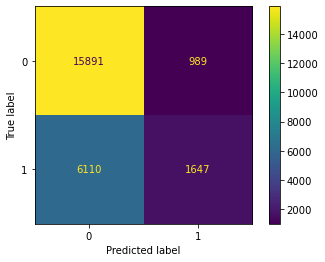

In [34]:
pred = model.predict(x_test_dum)
cm = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

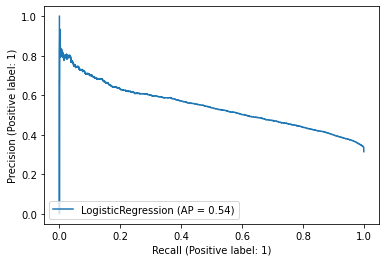

In [35]:
def pr(model, x_test):
    c = PrecisionRecallDisplay.from_estimator(model, x_test, y_test)
pr(model, x_test_dum)

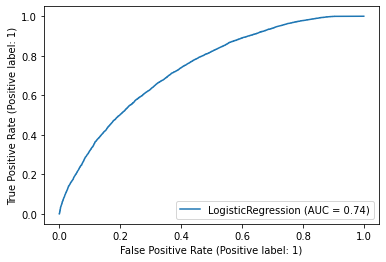

In [36]:
def auc(model, x_test):
    visual = RocCurveDisplay.from_estimator(model, x_test, y_test)
auc(model, x_test_dum)

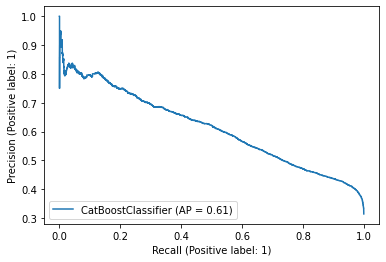

In [37]:
pr(cat_model, x_test)

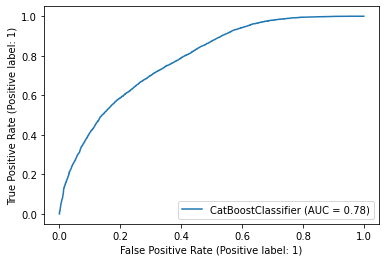

In [38]:
auc(cat_model, x_test)

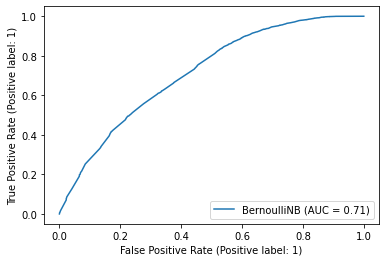

In [39]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(x_train_dum, y_train)
auc(model, x_test_dum)

In [40]:
y_test.value_counts()

0    16880
1     7757
Name: is_canceled, dtype: int64

Итак, мы имеем модель, которая предсказывает принадлежность к тому или иному классу. Во-первых, у нас изначально несколько несбалансированный сет. Во-вторых, валидационный сет тоже нельзя назвать идеально балансным. Однако, перед апсемплами и прочими играми попробуем сдвинуть трешхолд предикта. Для этого сформулируем, сколько нам вообще нужно найти потенциальных отказов:

In [41]:
TOTAL_SUM = 400_000
RETURN_RATE = .8

In [42]:
test_df_pred = test_df.copy()
test_df_pred['pred'] = model.predict(x_test_dum)
test_df_pred_cat = test_df.copy()
test_df_pred_cat['pred'] = cat_model.predict(x_test)

In [43]:
def new_income(df):
    new = df.query('pred == 1 and is_canceled == 1')
    return calculate_loss(df, loss=False) + calculate_loss(new, loss=True)

In [44]:
old_profit = calculate_loss(test_df)
print('Old profit:', old_profit)

Old profit: 45457380.0


In [45]:
new_profit = new_income(test_df_pred_cat)
print('New profit:', new_profit)

New profit: 46669996.0


In [46]:
def prevented_loss(df):
    loss = []
    for i in range(len(df)):
        if (df.iloc[i]['pred'] == 1) & (df.iloc[i]['is_canceled'] == 1):
            loss.append(df.iloc[i])
    loss = pd.DataFrame(loss)    
    return calculate_loss(loss, loss=True)

In [47]:
print('Prevented_loss by catboost:', prevented_loss(test_df_pred_cat))

Prevented_loss by catboost: 1212616.0


In [48]:
print('Prevented_loss by LogReg:', prevented_loss(test_df_pred))

Prevented_loss by LogReg: 943384.0


In [49]:
print('Old saldo:', saldo_test)

Old saldo: 45457380.0


In [50]:
print('New saldo:', saldo_test + prevented_loss(test_df_pred_cat))

New saldo: 46669996.0


Как будто можно как минимум подвигать трешхолд, чтобы выбирать не по вероятностям 0.5, а двигать для достижения большего реколла, однако, уже сейчас модель позволяет получить потенциальную выгоду свыше полутора миллионов рублей сверху суммы на разработку и внедрение, что можно назвать неплохим результатом. 

In [51]:
prob_cat = cat_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prob_cat)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.243669


In [52]:
prob_cat

array([0.64660628, 0.17753812, 0.44945205, ..., 0.34536257, 0.19956686,
       0.3707015 ])

In [53]:
squarer = lambda t: 1 if t>best_thresh else 0
vfunc = np.vectorize(squarer)

In [54]:
prob_cat_mod = vfunc(prob_cat)
prob_cat_mod

array([1, 0, 1, ..., 1, 0, 1])

In [55]:
test_df_pred_cat['pred'] = prob_cat_mod

In [56]:
print('Prevented_loss by catboost with mod thresh:', prevented_loss(test_df_pred_cat))

Prevented_loss by catboost with mod thresh: 3147136.0


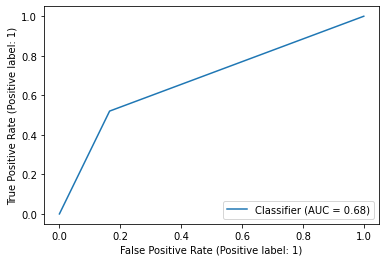

In [57]:
RocCurveDisplay.from_predictions(prob_cat_mod, y_test);

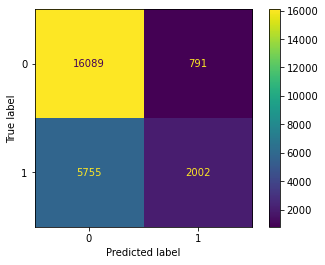

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test, cat_model.predict(x_test))).plot();

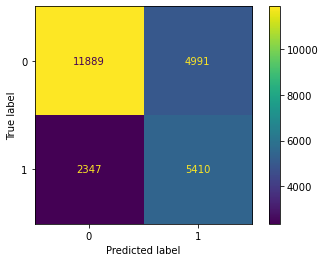

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_test, prob_cat_mod)).plot();

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [60]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

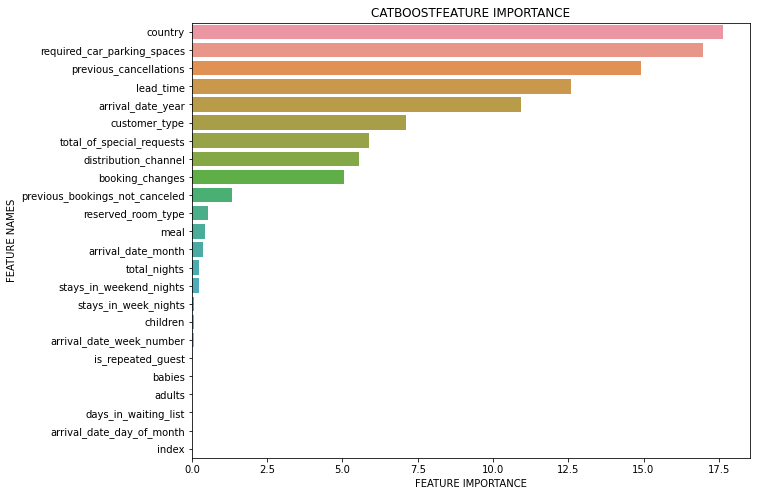

In [61]:
plot_feature_importance(cat_model.get_feature_importance(), x_train.columns,'CATBOOST')

In [62]:
df[df['is_canceled'] == 1]['country'].value_counts()

PRT    5076
ESP     864
FRA     748
GBR     711
ITA     595
       ... 
AND       1
SEN       1
ZMB       1
HND       1
PRI       1
Name: country, Length: 112, dtype: int64

Что ж. Самый ненадёжный клиент — тот, который уже ранее отменял бронь. Визуализируем всё шапом, чтобы получить наглядное представление о других категориях:

In [63]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(Pool(x_train, y_train, cat_features=categorical_indices))

In [64]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:50,:], x_train.iloc[0:50,:])

In [65]:
shap.force_plot(explainer.expected_value, shap_values[16,:], x_train.iloc[16,:])

К примеру, одной из самых "типовых" ненадёжных будет бронь "Transinient" типа и со страной "PRT"

### Шаг 6. Напишите общий вывод

Данные были загружены, предобработаны по необходимости, рассмотрены балансы классов, которые, однако, не сильно отразились на итоговом результате. 
Рассчитаны потенциальные потери от перенесённых броней, произведён рассчёт необходимой прибыли от модели.  
Эти показатели можно как улучшить, изменив трешхолд в сторону покрытия большего количества объектов первого класса, так и уменьшить, таким образом сохранив лояльность надёжных клиентов.  
Разумеется, финальное решение остаётся за бизнесом.  
Общий портрет "ненадёжного" посетителя отеля составлен с учётом трёх основных показателей, самым важным из которых является наличие "в анамнезе" отмен ранее. 